## The extended IMDB 5000 Movie Database analysis


In [51]:
import pandas as pd  
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # to use certain functions
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
from sklearn import linear_model # to use linear classifiers
%matplotlib inline
sns.set_style("dark")
mpl.style.use('ggplot')

Read the data from a .CSV fie and check the types

In [52]:
df = pd.read_csv("data/movie_metadata_upd_final.csv")
df = df.sample(frac=1).reset_index(drop=True)
NROWS = df.shape[0]
print("this database contains {} variables and {} rows".format(df.shape[1], NROWS))
df.head()

this database contains 42 variables and 4353 rows


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,tagline_pct_nouns,tagline_pct_adj,pct_action_fantasy,plot_complexity,rel_weekday,rel_quarter,director_sex,actor_1_sex,actor_2_sex,actor_3_sex
0,Color,E.L. Katz,193.0,88.0,3.0,307.0,Ethan Embry,3000.0,59379.0,Comedy|Crime|Drama|Horror|Thriller,...,11.1,11.1,0.0,6,4.0,1.0,M,M,M,F
1,Color,Harry Gantz,12.0,105.0,0.0,NaN,NaN,NaN,247740.0,Documentary|Drama,...,14.3,14.3,0.0,6,4.0,1.0,M,M,M,M
2,Color,Daniel Mellitz,NaN,NaN,0.0,15.0,Chelse Swain,1000.0,NaN,Comedy|Drama,...,NaN,NaN,0.0,10,6.0,3.0,M,M,M,F
3,Color,Patrice Leconte,61.0,112.0,83.0,8.0,Daniel Auteuil,2000.0,3058380.0,Drama|Romance,...,36.8,10.5,0.0,5,3.0,4.0,F,M,M,M
4,Color,Frank Marshall,55.0,109.0,155.0,293.0,Joe Don Baker,426.0,81022333.0,Action|Adventure|Mystery|Sci-Fi,...,16.7,0.0,25.0,6,3.0,3.0,M,M,M,M


Let's see what types are there:

In [53]:
df.dtypes

color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
m

## Handling types and missing values

Let us see how many missing values are there for each variable

In [54]:
df.count()-NROWS

color                        -14
director_name                  0
num_critic_for_reviews       -40
duration                     -12
director_facebook_likes        0
actor_3_facebook_likes       -16
actor_2_name                 -10
actor_1_facebook_likes        -7
gross                       -545
genres                         0
actor_1_name                  -7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                 -16
facenumber_in_poster         -13
plot_keywords               -139
movie_imdb_link                0
num_user_for_reviews         -15
language                      -5
country                       -1
content_rating              -252
budget                      -367
title_year                     0
actor_2_facebook_likes       -10
imdb_score                     0
aspect_ratio                -296
movie_facebook_likes           0
rel_date                     -53
tagline                     -655
tagline_pc

Here is a reasonable fix:
> **color**: fill with "Color" because these days nearly movies are shot in color (and we only consider movies released since 1991)  
> **num_critic_for_reviews**: perhaps, there were no reviews; set missing values to zero  
> **num_user_for_reviews**: as above
> **duration**: take the avrage duration across all movies  
> **actor_3_facebook_likes**: for now, assume it's possible that no FB user likes this actor - set zero  
> **actor_1_facebook_likes**: similar to the above  
> **actor_2_facebook_likes**: as above  
> **actor_2_name**: this is interesting; make it "Unknown Actor" because we don't really care (for the purposes of this project)  
> **actor_1_name**: similar to the above  
> **actor_3_name**: similar to the above  
> **gross**: this is a bit troubling, that so many groww figures are missing; anyway, set them to zero as there doesn't seem to be any more sensible solution right now  
> **facenumber_in_poster**: it is very much possible that there can be no faces in posters, so set to zero  
> **plot_keywords**: let's just add the word "missing"; surely, there are other a bit more complex solutions like to infer topic from the movie title or look it up on Wikipedia or something else  
> **language**: could be easily looked up; to save time, make it "unknown"  
> **country**: as above  
> **content_rating**: as above  
> **budget**: many missing figures! would normally find out (news, Wikipedia, etc.) but now set to the average budget  
> **aspect_ratio**: set to the most popular one  
> **rel_date**: have to be careful here; say, it's 01 January of that year  
> **tagline**: just "missing"  
> **tagline_pct_verbs**: zero  
> **tagline_pct_punkt**: as above  
> **tagline_pct_nouns**: as above  
> **tagline_pct_adj**: as above  
> **rel_weekday**: take the average across all available weekdays  
> **rel_quarter**: as above


In [55]:
df["color"] = df["color"].fillna("Color")
df["num_critic_for_reviews"] = df["num_critic_for_reviews"].fillna(0)
df["duration"] = df["duration"].fillna(df["duration"].mean())
df["actor_3_facebook_likes"] = df["actor_3_facebook_likes"].fillna(0)
df["actor_1_facebook_likes"] = df["actor_1_facebook_likes"].fillna(0)
df["actor_2_name"] = df["actor_2_name"].fillna("Unknown Actor")
df["actor_1_name"] = df["actor_1_name"].fillna("Unknown Actor")
df["actor_3_name"] = df["actor_3_name"].fillna("Unknown Actor")
df["gross"] = df["gross"].fillna(0)
df["facenumber_in_poster"] = df["facenumber_in_poster"].fillna(0)
df["plot_keywords"] = df["plot_keywords"].fillna("missing")
df["num_user_for_reviews"] = df["num_user_for_reviews"].fillna(0)
df["language"] = df["language"].fillna("unknown")
df["country"] = df["country"].fillna("unknown")
df["content_rating"] = df["content_rating"].fillna("unknown")
df["budget"] = df["budget"].fillna(df["budget"].mean())
df["actor_2_facebook_likes"] = df["actor_2_facebook_likes"].fillna(0)
df["aspect_ratio"] = df["aspect_ratio"].fillna(df["aspect_ratio"].mode().iloc[0])
df["rel_date"] = df["rel_date"].fillna(pd.to_datetime(df["title_year"]))  
df["tagline"] = df["tagline"].fillna("missing")
df["tagline_pct_verbs"] = df["tagline_pct_verbs"].fillna(0)
df["tagline_pct_punkt"] = df["tagline_pct_punkt"].fillna(0)
df["tagline_pct_nouns"] = df["tagline_pct_nouns"].fillna(0)
df["tagline_pct_adj"] = df["tagline_pct_adj"].fillna(0)
df["rel_weekday"] = df["rel_weekday"].fillna(df["rel_weekday"].mode().iloc[0])
df["rel_quarter"] = df["rel_quarter"].fillna(df["rel_quarter"].mode().iloc[0])

Add a new variable **profitability**, which will be defined by a profitability function as follows  
> f(movie): 1 if gross/budget > 1 (profitable) or 0 (flop) otherwise. 

In [56]:
df["profitability"] = df["gross"].divide(df["budget"], fill_value=0).apply(lambda _: 1 if _ > 1 else 0)

## Data Exploration

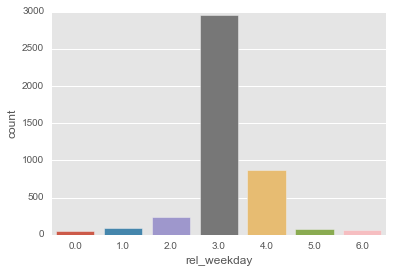

In [57]:
sns.countplot(x="rel_weekday", data=df)

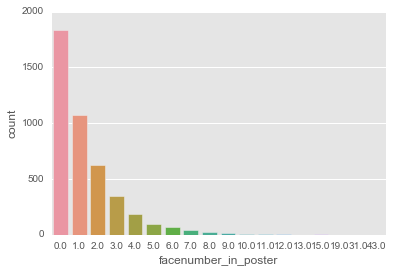

In [58]:
sns.countplot(x="facenumber_in_poster", data=df)

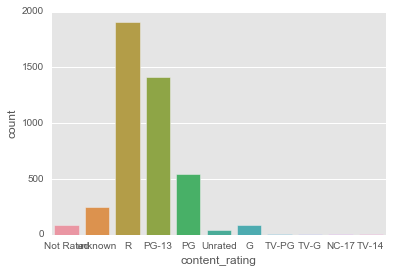

In [59]:
sns.countplot(x="content_rating", data=df)

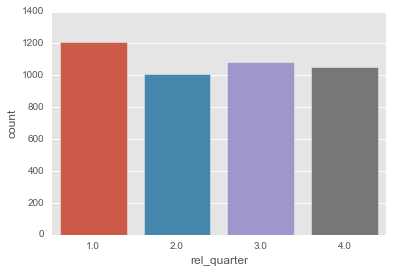

In [60]:
sns.countplot(x="rel_quarter", data=df)

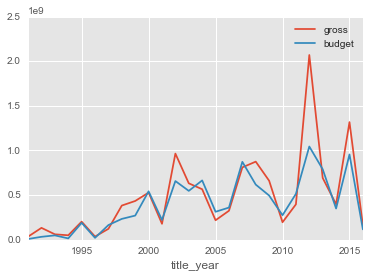

In [61]:
df[df["director_sex"]=="F"].groupby("title_year").sum()[["gross","budget"]].plot()


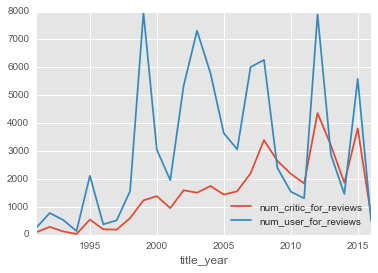

In [62]:
df[df["director_sex"]=="F"].groupby("title_year").sum()[["num_critic_for_reviews","num_user_for_reviews"]].plot()

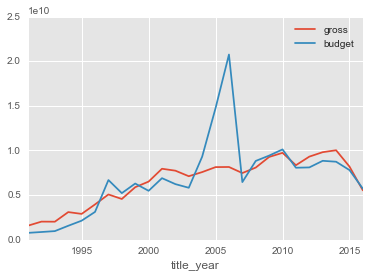

In [63]:
df[df["director_sex"]=="M"].groupby("title_year").sum()[["gross","budget"]].plot()


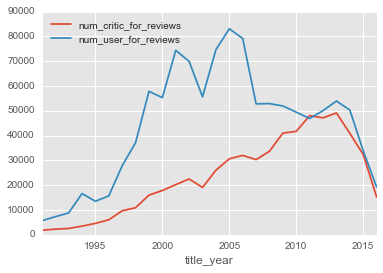

In [64]:
df[df["director_sex"]=="M"].groupby("title_year").sum()[["num_critic_for_reviews","num_user_for_reviews"]].plot()

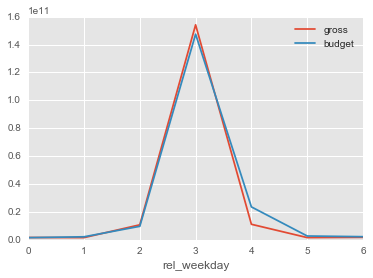

In [65]:
df.groupby("rel_weekday").sum()[["gross","budget"]].plot()

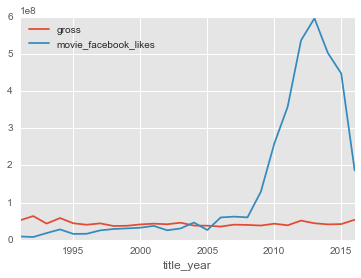

In [66]:
df.groupby("title_year").agg({"gross": np.mean, "movie_facebook_likes": lambda x: 100*sum(x)}).plot()

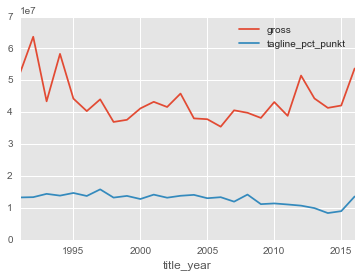

In [67]:
df.groupby("title_year").agg({"gross": np.mean, "tagline_pct_punkt": lambda x: 1000000*np.mean(x)}).plot()

## Prediction

In [68]:
vec = DictVectorizer(sparse=False)
# DictVectorizer expects data as a list of dictionaries, where each dictionary is a data row with column names as keys
# [ { 'director': 'M', 'budget': 25 }, { 'director': 'F', 'budget': 259 }, ...]

vars_for_prediction = ["num_critic_for_reviews","num_user_for_reviews","duration","director_facebook_likes","budget","rel_quarter","director_sex","plot_complexity"]
df_var = df[vars_for_prediction]
df_var_as_dict = df_var.T.to_dict().values()
df_var_vectorized_as_array = vec.fit_transform(df_var_as_dict)  # returns an numpy array
df_var_vectorized = pd.DataFrame(df_var_vectorized_as_array)

#vec.get_feature_names()

X_train, X_test, y_train, y_test = train_test_split(
    df_var_vectorized, df["profitability"], test_size=0.2, random_state=13)

### Logistic Regression

In [73]:
lreg = linear_model.LogisticRegression()
lreg.fit(X_train, y_train)
print("Logistic regression accuracy: {}".format(round(accuracy_score(y_test, lreg.predict(X_test)),3)))

Logistic regression accuracy: 0.598
